In [2]:
# Course URL:
# https://deeplearningcourses.com/c/natural-language-processing-with-deep-learning-in-python
# https://udemy.com/natural-language-processing-with-deep-learning-in-python

# You can get the data from this URL: http://www.cnts.ua.ac.be/conll2000/chunking/
# not considering context

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [3]:
class LogisticRegression:
    def __init__(self):
        pass

    def fit(self, X, Y, V=None, K=None, D=50, lr=10e-1, mu=0.99, batch_sz=100, epochs=6):
        if V is None:
            V = len(set(X)) # vocabulary size
        if K is None:
            K = len(set(Y))
        N = len(X)

        
        W = np.random.randn(V, K) / np.sqrt(V + K)
        b = np.zeros(K)
        self.W = theano.shared(W)
        self.b = theano.shared(b)
        self.params = [self.W, self.b]

        
        thX = T.ivector('X')
        thY = T.ivector('Y')

        py_x = T.nnet.softmax(self.W[thX] + self.b)
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        self.cost_predict_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        updates = [
            (p, p + mu*dp - lr*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - lr*g) for dp, g in zip(dparams, grads)
        ]
        
        train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates,
            allow_input_downcast=True
        )

        costs = []
        n_batches = N / batch_sz
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            print("epoch:", i)
            for j in xrange(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]

                c, p = train_op(Xbatch, Ybatch)
                costs.append(c)
                if j % 200 == 0:
                    print("i:", i, "j:", j, "n_batches:", n_batches, "cost:", c, "error:", np.mean(p != Ybatch))
        plt.plot(costs)
        plt.show()

    def score(self, X, Y):
        _, p = self.cost_predict_op(X, Y)
        return np.mean(p == Y)

    def f1_score(self, X, Y):
        _, p = self.cost_predict_op(X, Y)
        return f1_score(Y, p, average=None).mean()


def get_data(split_sequences=False):
    word2idx = {}
    tag2idx = {}
    word_idx = 0
    tag_idx = 0
    Xtrain = []
    Ytrain = []
    currentX = []
    currentY = []
    for line in open('conll2000_data/train.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word not in word2idx:
                word2idx[word] = word_idx
                word_idx += 1
            currentX.append(word2idx[word])
            
            if tag not in tag2idx:
                tag2idx[tag] = tag_idx
                tag_idx += 1
            currentY.append(tag2idx[tag])
        elif split_sequences:
            Xtrain.append(currentX)
            Ytrain.append(currentY)
            currentX = []
            currentY = []

    if not split_sequences:
        Xtrain = currentX
        Ytrain = currentY

    # load and score test data
    Xtest = []
    Ytest = []
    currentX = []
    currentY = []
    for line in open('conll2000_data/test.txt'):
        line = line.rstrip()
        if line:
            r = line.split()
            word, tag, _ = r
            if word in word2idx:
                currentX.append(word2idx[word])
            else:
                currentX.append(word_idx) # use this as unknown
            currentY.append(tag2idx[tag])
        elif split_sequences:
            Xtest.append(currentX)
            Ytest.append(currentY)
            currentX = []
            currentY = []
    if not split_sequences:
        Xtest = currentX
        Ytest = currentY

    return Xtrain, Ytrain, Xtest, Ytest, word2idx

def main():
    Xtrain, Ytrain, Xtest, Ytest, word2idx = get_data()

    # convert to numpy arrays
    Xtrain = np.array(Xtrain)
    Ytrain = np.array(Ytrain)

    # convert Xtrain to indicator matrix
    N = len(Xtrain)
    V = len(word2idx) + 1
    print("vocabulary size:", V)
    # Xtrain_indicator = np.zeros((N, V))
    # Xtrain_indicator[np.arange(N), Xtrain] = 1

    # decision tree
    dt = DecisionTreeClassifier()

    # without indicator
    dt.fit(Xtrain.reshape(N, 1), Ytrain)
    print("dt train score:", dt.score(Xtrain.reshape(N, 1), Ytrain)) # reshpe from 2D to 1D
    p = dt.predict(Xtrain.reshape(N, 1))
    print("dt train f1:", f1_score(Ytrain, p, average=None).mean())

    # with indicator -- too slow!!
    # dt.fit(Xtrain_indicator, Ytrain)
    # print "dt score:", dt.score(Xtrain_indicator, Ytrain)

    # train and score
    model = LogisticRegression()
    model.fit(Xtrain, Ytrain, V=V)
    print("training complete")
    print("lr train score:", model.score(Xtrain, Ytrain))
    print("lr train f1:", model.f1_score(Xtrain, Ytrain))


    Ntest = len(Xtest)
    Xtest = np.array(Xtest)
    Ytest = np.array(Ytest)
    # convert Xtest to indicator
    # Xtest_indicator = np.zeros((Ntest, V))
    # Xtest_indicator[np.arange(Ntest), Xtest] = 1

    # decision tree test score
    print("dt test score:", dt.score(Xtest.reshape(Ntest, 1), Ytest))
    p = dt.predict(Xtest.reshape(Ntest, 1))
    print("dt test f1:", f1_score(Ytest, p, average=None).mean())
    # print "dt test score:", dt.score(Xtest_indicator, Ytest) # too slow!

    # logistic test score -- too slow!!
    print("lr test score:", model.score(Xtest, Ytest))
    print("lr test f1:", model.f1_score(Xtest, Ytest))

### for pythonfile
# if __name__ == '__main__':
#     main()

('vocabulary size:', 19123)
('dt train score:', 0.96495959419441069)
('dt train f1:', 0.90785869693609766)


C:\Users\user\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('epoch:', 0)
('i:', 0, 'j:', 0, 'n_batches:', 2117, 'cost:', array(3.7859724823455054), 'error:', 1.0)
('i:', 0, 'j:', 200, 'n_batches:', 2117, 'cost:', array(0.8256471225505664), 'error:', 0.23000000000000001)
('i:', 0, 'j:', 400, 'n_batches:', 2117, 'cost:', array(0.5188224023986459), 'error:', 0.14999999999999999)
('i:', 0, 'j:', 600, 'n_batches:', 2117, 'cost:', array(0.447730364996386), 'error:', 0.11)
('i:', 0, 'j:', 800, 'n_batches:', 2117, 'cost:', array(0.7115932833172302), 'error:', 0.20999999999999999)
('i:', 0, 'j:', 1000, 'n_batches:', 2117, 'cost:', array(0.42903269266517974), 'error:', 0.11)
('i:', 0, 'j:', 1200, 'n_batches:', 2117, 'cost:', array(0.6769480606888924), 'error:', 0.19)
('i:', 0, 'j:', 1400, 'n_batches:', 2117, 'cost:', array(0.3745468832762858), 'error:', 0.10000000000000001)
('i:', 0, 'j:', 1600, 'n_batches:', 2117, 'cost:', array(0.34718140682221554), 'error:', 0.11)
('i:', 0, 'j:', 1800, 'n_batches:', 2117, 'cost:', array(0.3519137208026335), 'error:',

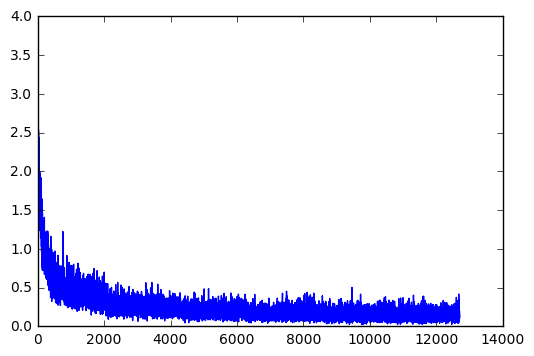

training complete
('lr train score:', 0.95973116324323304)
('lr train f1:', 0.89457092865645549)
('dt test score:', 0.91683728391413555)
('dt test f1:', 0.87171823428960749)
('lr test score:', 0.91065284842856242)
('lr test f1:', 0.85854136871401532)


In [4]:
main()